In [15]:
# general imports
import numpy as np
import pandas as pd

# scipy imports
from scipy.fftpack import fft
from scipy.io import wavfile

# custom classes
%run classes/measure.py
%run classes/note.py

class Music:
    
    def __init__(self, 
                 time_signature=(4, 4),
                 tempo=60,
                 ver_number="0.00"):
            
        self.time_signature = time_signature
        self.tempo = tempo
        self.ver_number = ver_number # version number of decoder

    def read(self, input_path, is_wav_format=True):
        self.input_path = input_path
        if is_wav_format:
            self.sample_rate, self.raw = wavfile.read(input_path)
        self.chan1, self.chan2 = zip(*self.raw)
        
    def compile_music(self, window=0, DIFF=0):
        self.measures = list()
        
        peaks = self.find_peaks(window, DIFF)
        notes = self.get_notes(peaks)
#         notes = self.filter_notes(notes)
#         for i, note in enumerate(notes):
#             measure = Measure(i+1)
#             measure.addNote(note)
#             self.addMeasure(measure)
        return notes
    
    def get_notes(self, peaks, inspection_width=10000, max_pitch=8000, use_chan1=True):
        notes = list()
        for peak, loudness in peaks:
            if use_chan1:
                inspection_zone = self.chan1[peak: peak+inspection_width]
                fft_data = np.abs(fft(inspection_zone))
                
                conversion_factor = self.sample_rate / len(fft_data)
                max_signal = max(fft_data)
                resonant_freqs = (-fft_data[:max_pitch]).argsort()
                timestamp = peak #/ self.sample_rate

                for freq in resonant_freqs:
                    signal = fft_data[freq]
                    if signal < max_signal * 0.4:
                        break
                    note = Note(freq * conversion_factor, signal, loudness, timestamp)
                    notes.append(note.getInfo())
        notes = pd.DataFrame(notes, columns=["time", "id", "signal", "pitch", "given_pitch",
                                             "loudness", "duration", "note", "octave", "alter"])
        return notes

    # ideally this is when dynamics will come in
    def filter_notes(self, notes):
        N = len(notes)
        to_delete = list()
        for i in range(1, N):
            if notes.iloc[i - 1].given_pitch == notes.iloc[i].given_pitch:
                to_delete.append(i)
        for index in list(reversed(to_delete)):
            notes.drop([index])
        return notes
    
    def find_peaks(self):
        # this comes out to around a tenth of a second.
        # notes played within this interval will be counted as one
        separation = 5000
        
        peaks = list()
        for i in range(separation, len(self.chan1) - separation):
            prv = self.chan1[i - separation: i]
            nxt = self.chan1[i+1: i+separation+1]
            if chan1[i] > max(prv) and self.chan1[i] > max(nxt) and self.chan1[i] > 5000:
                if len(peaks) == 0 or i - peaks[-1] > separation:
                    peaks.append(i)
        return peaks
        
    def addMeasure(self, measure):
        self.measures.append(measure)

In [ ]:
def filt(notes):
    
    return notes

In [50]:
music = Music()
music.read('sounds/wav/cello_pluck/multi/a3_d3.wav')
notes = music.compile_music(window=400, DIFF=2000)
notes
# notes.groupby("time", "note")

,time,id,signal,pitch,given_pitch,loudness,duration,note,octave,alter
0,80400,46,6.169508e+07,216.0,220.00,7608.630,4,A,3,0
1,80800,46,6.271625e+07,216.0,220.00,12258.298,4,A,3,0
2,81600,46,6.090092e+07,216.0,220.00,12369.845,4,A,3,0
3,82000,46,5.992125e+07,216.0,220.00,15461.570,4,A,3,0
4,165600,39,2.550394e+07,144.0,146.83,7108.685,4,D,3,0


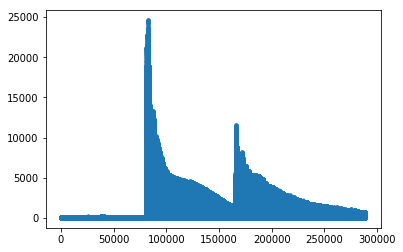

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.abs(music.chan1), ".")

In [52]:
mx = np.abs(music.chan1).argmax()
mx

82392

In [53]:
np.abs(music.chan1)[mx]

24607

In [79]:
def find_peaks(chan1):
    separation = 5000 
    peaks = list()
    for i in range(separation, len(chan1) - separation):
        prv = chan1[i - separation: i]
        nxt = chan1[i+1: i+separation+1]
        if chan1[i] > max(prv) and chan1[i] > max(nxt) and chan1[i] > 5000:
            if len(peaks) == 0 or i - peaks[-1] > separation:
                peaks.append(i)
    return peaks

In [81]:
find_peaks(music.chan1)

[82279, 165943]

In [78]:
5000 / music.sample_rate

0.10416666666666667